In [1]:
import keras

Using TensorFlow backend.


# 특성 추출 ( 생략 )

# 추출 특성 적재

In [121]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from sklearn.utils import shuffle
file_path = 'flower_features.csv'


In [122]:
embedded_images = pd.read_csv(file_path)
embedded_images.drop(['image name', 'image'], axis=1, inplace=True)
embedded_images = pd.get_dummies(embedded_images, columns = ['category'])

In [16]:
embedded_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3670 entries, 0 to 3669
Columns: 2053 entries, n0 to category_tulips
dtypes: float64(2048), uint8(5)
memory usage: 57.4 MB


In [165]:
# Shuffle the data
embedded_images = shuffle(embedded_images, random_state=42)

# Convert to numpy array after shuffling
embedded_images = np.array(embedded_images)

train_set = np.array(embedded_images[:-369])
val_set = np.array(embedded_images[-369:])

num_categories = 5
train_labels = train_set[:, -num_categories:]
train_data = train_set[:, :-num_categories]
val_labels = val_set[:, -num_categories:]
val_data = val_set[:, :-num_categories]

# Convert to TensorFlow Datasets
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size).repeat(tf.data.AUTOTUNE)
train_datset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [219]:
inputs = keras.Input(shape=(2048,))
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dropout(0.4)(inputs)
outputs = keras.layers.Dense(5, activation = 'softmax')(x)

classifier = keras.Model(inputs, outputs)

In [220]:
LAEARNING_RATE=0.0009

classifier.compile(optimizer=keras.optimizers.Adam(learning_rate=LAEARNING_RATE),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# 모델 학습

In [ ]:
steps_per_epoch = len(train_data) // batch_size
validation_steps = len(val_data) // batch_size

EPOCHS = 200

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = 'val_accuracy',
        patience = 30,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="flower_best_4.keras",
        monitor='val_loss',
        save_best_only=True
    )
]

fit_history =classifier.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    shuffle=True,
    callbacks=callbacks
)

# 학습 곡선

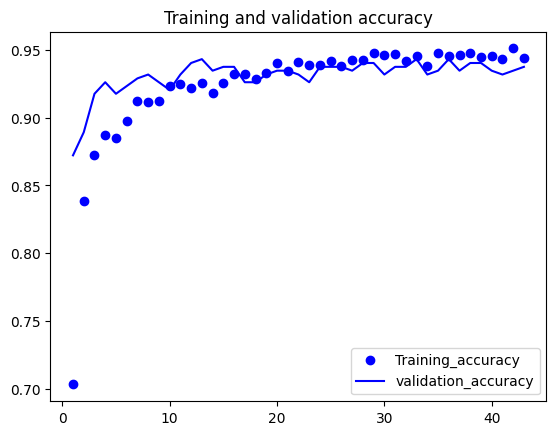

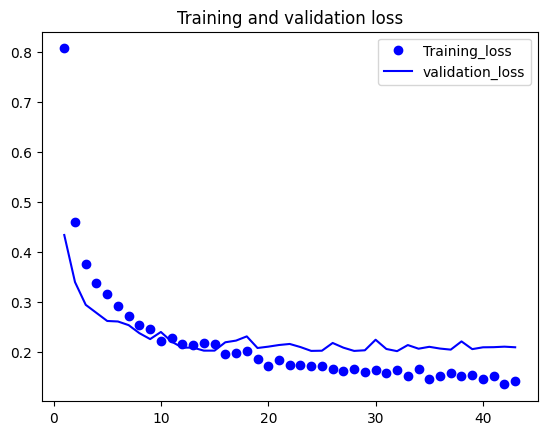

In [222]:
import matplotlib.pyplot as plt

accuracy = fit_history.history["accuracy"]
val_accuracy = fit_history.history["val_accuracy"]
loss = fit_history.history["loss"]
val_loss = fit_history.history["val_loss"]
epochs = range(1, len(accuracy)+1)

plt.plot(epochs, accuracy, "bo", label="Training_accuracy")
plt.plot(epochs, val_accuracy, "b-", label="validation_accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training_loss")
plt.plot(epochs, val_loss, "b-", label="validation_loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [53]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 16
image_height = 299
image_width = 299
# 폴더 구조로 카테고리를 분류하기 위해
train_dir = './flower_photos'
test_dir = './test'


train = ImageDataGenerator(
    rescale = 1./255,
    # rotation_range = 10,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.1,
    # zoom_range=0.1,
    validation_split = 0.2   # 검증 데이터 분할
    )
    
# test_generator = train.flow_from_directory(train_dir,
#                                             target_size = (image_height, image_width),
#                                             color_mode = 'rgb',
#                                             batch_size=BATCH_SIZE,
#                                             seed=1,
#                                             shuffle=True,
#                                             class_mode="categorical",
#                                             subset = 'training')   # training

test_generator = train.flow_from_directory(train_dir,
                                            target_size = (image_height, image_width),
                                            color_mode = 'rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode="categorical",
                                            subset = 'validation')   # validation

test = ImageDataGenerator(rescale = 1./255)

test_generator = train.flow_from_directory(test_dir,
                                            target_size = (image_height, image_width),
                                            color_mode = 'rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode="categorical")

Found 731 images belonging to 5 classes.
Found 1894 images belonging to 5 classes.


In [54]:
import os
import keras

import tensorflow as tf

classifier_path = "flower_best_2.keras"
classifier = tf.keras.models.load_model(classifier_path)
classifier.trainable = False

conv_base = keras.applications.InceptionV3(weights="imagenet", include_top=False)
conv_base.trainable = False

inputs = keras.Input(shape=(None, None, 3))
#x = keras.applications.inception_v3.preprocess_input(inputs)
x = conv_base(inputs)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = classifier(x)
model=keras.Model(inputs=inputs, outputs=outputs)

model = keras.Model(inputs, outputs)
model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics=["accuracy"])


In [36]:
# 테스트 데이터 예측
predictions = model.predict(test_generator)

In [45]:
loss, acc = model.evaluate(test_generator)

46/46 [==============================] - 10s 135ms/step - loss: 0.1629 - accuracy: 0.9488


## 정확도 혼동행렬

In [ ]:
import keras
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# 모델 파일 경로
model_path = 'C:/Users/ligoan/OneDrive/바탕 화면/I/repository/quest/DLThon/학습한 모델들/my_conv_catdog37_try_8_inceptionV3_image_aug_no_limit_input_size_224_224_75_0.97_0.10/my_conv_catdog37_try_6_inceptionV3__image_aug_no_limit_input_size_224_224_75_0.97_0.10.keras'

# 모델 로드
test_model = keras.models.load_model(model_path)

# 테스트 데이터 예측
predictions = test_model.predict(test_ds)

In [ ]:
# 테스트 데이터 평가
evaluation = model.evaluate(test_generator)

In [ ]:
import numpy as np

# Assuming `one_hot_labels` is your original matrix generated from predicted labels
# Example:
# one_hot_labels = np.random.rand(1000, 10)  # For demonstration, a matrix with 1000 rows and 10 columns

# Define the ranges
ranges = [
    98, 100, 100, 100, 100, 100, 100, 88, 99, 100, 100, 97, 100, 100, 100, 100, 100, 100, 99, 100, 100, 100,
    100, 100, 100, 100, 100, 100, 100, 100, 99, 100, 100, 100, 89, 100, 100
]

# Check the total number of rows to ensure no index error
if sum(ranges) > one_hot_labels.shape[0]:
    raise ValueError("The total number of rows to be summed exceeds the number of rows in the matrix.")

# Generate the new matrix
new_matrix = []
start_index = 0

# Process the first range (98 rows from the beginning to the 0th row)
end_index = start_index + ranges[0]
summed_row = np.sum(one_hot_labels[start_index:end_index, :], axis=0)
new_matrix.append(summed_row)
start_index = end_index

# Process the remaining ranges
for r in ranges[1:]:
    end_index = start_index + r
    summed_row = np.sum(one_hot_labels[start_index:end_index, :], axis=0)
    new_matrix.append(summed_row)
    start_index = end_index

new_matrix = np.array(new_matrix)

print("Original matrix shape:", one_hot_labels.shape)
print("New matrix shape:", new_matrix.shape)


In [ ]:
sum(new_matrix[0])

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

breeds = [
    "Abyssinian",
    "american_bulldog",
    "american_pit_bull_terrier",
    "basset_hound",
    "beagle",
    "Bengal",
    "Birman",
    "Bombay",
    "boxer",
    "British_Shorthair",
    "chihuahua",
    "Egyptian_Mau",
    "english_cocker_spaniel",
    "english_setter",
    "german_shorthaired",
    "great_pyrenees",
    "havanese",
    "japanese_chin",
    "keeshond",
    "leonberger",
    "Maine_Coon",
    "miniature_pinscher",
    "newfoundland",
    "Persian",
    "pomeranian",
    "pug",
    "Ragdoll",
    "Russian_Blue",
    "saint_bernard",
    "samoyed",
    "scottish_terrier",
    "shiba_inu",
    "Siamese",
    "Sphynx",
    "staffordshire_bull_terrier",
    "wheaten_terrier",
    "yorkshire_terrier"
]

# Create a mapping from breed names to numerical labels
breed_to_label = {breed: idx for idx, breed in enumerate(breeds)}

# Assuming you have the original true labels for the one_hot_labels
original_true_labels = np.argmax(one_hot_labels, axis=1)  # Example: true labels from one_hot_labels

# Generate true labels for the new_matrix
true_labels = []
start_index = 0
for r in ranges:
    end_index = start_index + r
    # Assuming the true label for the summed row is the most frequent label in the range
    true_label = np.bincount(original_true_labels[start_index:end_index]).argmax()
    true_labels.append(true_label)
    start_index = end_index

true_labels = np.array(true_labels)
predicted_labels = np.argmax(new_matrix, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False)

# Set x-axis and y-axis labels
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

# Move x-axis labels just below the title
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

plt.title('Confusion Matrix')
plt.show()


In [ ]:
import pandas as pd
confusion_matrix = pd.DataFrame(new_matrix)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix_df = pd.DataFrame(new_matrix, index=breeds, columns=range(len(breeds))).astype(int)


In [ ]:
# Visualize confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='YlGnBu',linewidth = '.2')

# Set x-axis and y-axis labels
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

# Move x-axis labels just below the title
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

plt.show()

# 사전 훈련된 모델 inceptionV3

In [47]:
import keras
conv_base = keras.applications.InceptionV3(weights="imagenet", include_top=False)
conv_base.trainable = False

In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 20
image_height = 224
image_width = 224
# 폴더 구조로 카테고리를 분류하기 위해
train_dir = './flower_photos'


train = ImageDataGenerator(
    rescale = 1./255,
    # rotation_range = 10,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.1,
    # zoom_range=0.1,
    validation_split = 0.2   # 검증 데이터 분할
    )
    
train_generator = train.flow_from_directory(train_dir,
                                            target_size = (image_height, image_width),
                                            color_mode = 'rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode="categorical",
                                            subset = 'training')   # training

val_generator = train.flow_from_directory(train_dir,
                                            target_size = (image_height, image_width),
                                            color_mode = 'rgb',
                                            batch_size=BATCH_SIZE,
                                            seed=1,
                                            shuffle=True,
                                            class_mode="categorical",
                                            subset = 'validation')   # validation

#test = ImageDataGenerator(rescale = 1./255)

# test_generator = train.flow_from_directory(train_dir,
#                                             target_size = (image_height, image_width),
#                                             color_mode = 'rgb',
#                                             batch_size=BATCH_SIZE,
#                                             seed=1,
#                                             shuffle=True,
#                                             class_mode="categorical")

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [52]:
import keras
import os
import keras

conv_base = keras.applications.InceptionV3(weights="imagenet", include_top=False)
conv_base.trainable = False

inputs = keras.Input(shape=(None, None, 3))
#x = keras.applications.inception_v3.preprocess_input(inputs)
x = conv_base(inputs)
x = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Dropout(0.7)(x)
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(5, activation = "softmax")(x)

model = keras.Model(inputs, outputs)
model.compile(loss = "categorical_crossentropy",
              optimizer = "rmsprop",
              metrics=["accuracy"])

EPOCHS = 150

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = 'val_accuracy',
        patience = 10,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("flower_best_5.keras"),
        monitor='val_loss',
        save_best_only=True
    )
]

fit_history = model.fit(train_generator,
                        epochs = EPOCHS,
                        validation_data = val_generator,
                        callbacks=callbacks)

Epoch 1/150
147/147 [==============================] - 49s 281ms/step - loss: 1.0147 - accuracy: 0.6355 - val_loss: 0.5115 - val_accuracy: 0.8003
Epoch 2/150
147/147 [==============================] - 56s 377ms/step - loss: 0.3816 - accuracy: 0.8711 - val_loss: 0.5075 - val_accuracy: 0.8181
Epoch 3/150
147/147 [==============================] - 40s 273ms/step - loss: 0.3056 - accuracy: 0.8923 - val_loss: 0.4595 - val_accuracy: 0.8290
Epoch 4/150
147/147 [==============================] - 41s 280ms/step - loss: 0.2452 - accuracy: 0.9132 - val_loss: 0.4474 - val_accuracy: 0.8276
Epoch 5/150
147/147 [==============================] - 46s 312ms/step - loss: 0.2143 - accuracy: 0.9346 - val_loss: 0.4397 - val_accuracy: 0.8427
Epoch 6/150
147/147 [==============================] - 44s 298ms/step - loss: 0.1911 - accuracy: 0.9415 - val_loss: 0.4102 - val_accuracy: 0.8536
Epoch 7/150
147/147 [==============================] - 47s 321ms/step - loss: 0.1646 - accuracy: 0.9449 - val_loss: 0.4699 -

KeyboardInterrupt: 